In [1]:
# NLP Analysis: Named Entity Recognition (NER) and Part-of-Speech (PoS) Tagging
# Climate Fever Dataset Analysis
# Author: Marco Gonzalez

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


NLP Analysis: NER and PoS Tagging on Climate Fever Dataset
This notebook performs comprehensive NLP analysis including:
- Named Entity Recognition (NER)
- Part-of-Speech (PoS) Tagging
- Data visualization and insights


## Installation Instructions

Before running this notebook, please install the required dependencies using the requirements.txt file:

```bash
# Install dependencies
pip install -r requirements.txt

# Download spaCy English model
python -m spacy download en_core_web_sm
```

**Required packages:**
- pandas, numpy, matplotlib, seaborn (data science)
- nltk, spacy, textblob (NLP)
- wordcloud, plotly (visualization)
- networkx (graph analysis)


In [2]:
# Import NLP libraries and download required resources
import nltk
import spacy
from collections import Counter, defaultdict
import re
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from textblob import TextBlob
import subprocess
import sys

print("Setting up NLP resources...")

# Download NLTK data (automatic download with error handling)
print("Downloading NLTK resources...")
nltk_resources = ['punkt', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words', 'stopwords']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}')
        print(f"[OK] {resource} already available")
    except LookupError:
        try:
            print(f"Downloading {resource}...")
            nltk.download(resource, quiet=True)
            print(f"[OK] {resource} downloaded successfully")
        except Exception as e:
            print(f"Warning: Could not download {resource}: {e}")

# Load spaCy model with better error handling
print("\nLoading spaCy model...")
try:
    nlp = spacy.load("en_core_web_sm")
    print("[OK] spaCy English model loaded successfully")
except OSError:
    print("ERROR: spaCy English model not found!")
    print("Please run: python -m spacy download en_core_web_sm")
    print("Or install it using the installation instructions above.")
    raise SystemExit("spaCy model required for analysis")

print("\nAll NLP resources ready for analysis!")


Setting up NLP resources...
[OK] punkt already available
[OK] averaged_perceptron_tagger downloaded successfully
[OK] maxent_ne_chunker downloaded successfully
[OK] words downloaded successfully
[OK] stopwords downloaded successfully

Loading spaCy model...
[OK] spaCy English model loaded successfully

All NLP resources ready for analysis!


## Dataset Loading and Exploration

The Climate Fever dataset contains claims about climate change along with supporting evidence. We'll focus on the main claims for our NLP analysis.


In [3]:
# Load the Climate Fever dataset
print("Loading Climate Fever dataset...")
df = pd.read_csv('climate-fever.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"Main text column: 'claim'")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Total records: {len(df):,}")
print(f"Unique claims: {df['claim'].nunique():,}")

# Check for missing values in key columns
print(f"\nMissing values in 'claim': {df['claim'].isnull().sum()}")

# Display sample claims
print("\n" + "="*50)
print("SAMPLE CLAIMS")
print("="*50)
for i, claim in enumerate(df['claim'].head(3)):
    print(f"\n{i+1}. {claim[:200]}{'...' if len(claim) > 200 else ''}")

# Basic statistics about claim lengths
claim_lengths = df['claim'].str.len()
print(f"\n" + "="*50)
print("CLAIM LENGTH STATISTICS")
print("="*50)
print(f"Average length: {claim_lengths.mean():.1f} characters")
print(f"Median length: {claim_lengths.median():.1f} characters")
print(f"Min length: {claim_lengths.min()} characters")
print(f"Max length: {claim_lengths.max()} characters")


Loading Climate Fever dataset...
Dataset shape: (1535, 53)
Columns: 53
Main text column: 'claim'

DATASET OVERVIEW
Total records: 1,535
Unique claims: 1,535

Missing values in 'claim': 0

SAMPLE CLAIMS

1. Global warming is driving polar bears toward extinction

2. The sun has gone into ‘lockdown’ which could cause freezing weather, earthquakes and famine, say scientists

3. The polar bear population has been growing.

CLAIM LENGTH STATISTICS
Average length: 123.4 characters
Median length: 115.0 characters
Min length: 26 characters
Max length: 406 characters


In [4]:
# Data preprocessing function
def preprocess_text(text):
    """
    Preprocess text for NLP analysis
    - Remove unnecessary characters
    - Handle encoding issues
    - Clean whitespace
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and handle encoding
    text = str(text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove quotes at the beginning and end (common in the dataset)
    text = text.strip('"').strip("'").strip()
    
    return text

# Apply preprocessing
print("Preprocessing claims...")
df['claim_processed'] = df['claim'].apply(preprocess_text)

# Remove empty claims after preprocessing
df = df[df['claim_processed'].str.len() > 0].reset_index(drop=True)

print("Preprocessing complete!")
print(f"Final dataset size: {len(df)} claims")

# Create a sample for analysis (to manage computation time)
# We'll use the first 500 claims for detailed analysis
SAMPLE_SIZE = 500
df_sample = df.head(SAMPLE_SIZE).copy()

print(f"Using sample of {len(df_sample)} claims for detailed NLP analysis")
print(f"Sample represents {len(df_sample)/len(df)*100:.1f}% of the dataset")


Preprocessing claims...
Preprocessing complete!
Final dataset size: 1535 claims
Using sample of 500 claims for detailed NLP analysis
Sample represents 32.6% of the dataset


## Named Entity Recognition (NER) Analysis

Named Entity Recognition identifies and classifies named entities in text into predefined categories such as:
- **PERSON**: People's names
- **ORG**: Organizations, companies, agencies
- **GPE**: Geopolitical entities (countries, cities, states)
- **DATE**: Dates and times
- **MONEY**: Monetary values
- **PERCENT**: Percentages
- **CARDINAL**: Numbers that don't fall into other categories


In [5]:
# Named Entity Recognition using spaCy
def extract_entities_spacy(text):
    """Extract named entities using spaCy"""
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append({
            'text': ent.text,
            'label': ent.label_,
            'description': spacy.explain(ent.label_),
            'start': ent.start_char,
            'end': ent.end_char
        })
    return entities

# Extract named entities using NLTK
def extract_entities_nltk(text):
    """Extract named entities using NLTK"""
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    chunks = nltk.ne_chunk(pos_tags)
    
    entities = []
    for chunk in chunks:
        if hasattr(chunk, 'label'):
            entity_text = ' '.join([token for token, pos in chunk.leaves()])
            entities.append({
                'text': entity_text,
                'label': chunk.label(),
                'description': chunk.label()
            })
    return entities

print("Performing Named Entity Recognition...")
print("This may take a few minutes for the sample dataset...")

# Process entities with spaCy (more comprehensive)
all_entities_spacy = []
entity_stats = defaultdict(int)

for idx, claim in enumerate(df_sample['claim_processed']):
    if idx % 100 == 0:
        print(f"   Processed {idx}/{len(df_sample)} claims...")
    
    entities = extract_entities_spacy(claim)
    all_entities_spacy.extend(entities)
    
    # Count entity types
    for entity in entities:
        entity_stats[entity['label']] += 1

print("NER Analysis Complete!")
print(f"Found {len(all_entities_spacy)} total entities")
print(f"Found {len(entity_stats)} different entity types")


Performing Named Entity Recognition...
This may take a few minutes for the sample dataset...
   Processed 0/500 claims...
   Processed 100/500 claims...
   Processed 200/500 claims...
   Processed 300/500 claims...
   Processed 400/500 claims...
NER Analysis Complete!
Found 790 total entities
Found 17 different entity types


In [6]:
# Analyze and display NER results
print("=" * 60)
print("NAMED ENTITY RECOGNITION RESULTS")
print("=" * 60)

# Top entity types
print("\nTOP ENTITY TYPES:")
sorted_entities = sorted(entity_stats.items(), key=lambda x: x[1], reverse=True)
for entity_type, count in sorted_entities[:10]:
    description = spacy.explain(entity_type) or entity_type
    print(f"  {entity_type:12} ({description:30}): {count:4d}")

# Most common entities by type
print("\nMOST COMMON ENTITIES BY TYPE:")
entity_text_counts = defaultdict(lambda: defaultdict(int))

for entity in all_entities_spacy:
    entity_text_counts[entity['label']][entity['text']] += 1

for entity_type, count in sorted_entities[:5]:
    print(f"\n{entity_type} ({spacy.explain(entity_type) or entity_type}):")
    top_entities = sorted(entity_text_counts[entity_type].items(), key=lambda x: x[1], reverse=True)[:5]
    for entity_text, freq in top_entities:
        print(f"  - {entity_text:25} ({freq} times)")

# Sample entities in context
print("\n" + "=" * 60)
print("SAMPLE ENTITIES IN CONTEXT")
print("=" * 60)

sample_claims_with_entities = []
for idx, claim in enumerate(df_sample['claim_processed'][:10]):
    entities = extract_entities_spacy(claim)
    if entities:
        sample_claims_with_entities.append((claim, entities))

for i, (claim, entities) in enumerate(sample_claims_with_entities[:3]):
    print(f"\n{i+1}. Claim: {claim[:100]}...")
    print("   Entities found:")
    for entity in entities:
        print(f"     - {entity['text']:20} -> {entity['label']} ({entity['description']})")


NAMED ENTITY RECOGNITION RESULTS

TOP ENTITY TYPES:
  DATE         (Absolute or relative dates or periods):  247
  ORG          (Companies, agencies, institutions, etc.):   92
  CARDINAL     (Numerals that do not fall under another type):   92
  LOC          (Non-GPE locations, mountain ranges, bodies of water):   90
  GPE          (Countries, cities, states     ):   82
  PERSON       (People, including fictional   ):   47
  QUANTITY     (Measurements, as of weight or distance):   46
  PRODUCT      (Objects, vehicles, foods, etc. (not services)):   19
  PERCENT      (Percentage, including "%"     ):   18
  MONEY        (Monetary values, including unit):   13

MOST COMMON ENTITIES BY TYPE:

DATE (Absolute or relative dates or periods):
  - today                     (11 times)
  - decades                   (6 times)
  - April                     (5 times)
  - 2016                      (4 times)
  - 2017                      (3 times)

ORG (Companies, agencies, institutions, etc.):
  - IP

## Part-of-Speech (PoS) Tagging Analysis

Part-of-Speech tagging assigns grammatical categories to each word in a text. Common PoS tags include:
- **NN/NNS**: Noun (singular/plural)
- **VB/VBZ/VBG**: Verb (base form/3rd person singular/gerund)
- **JJ/JJR/JJS**: Adjective (positive/comparative/superlative)
- **RB/RBR/RBS**: Adverb (positive/comparative/superlative)
- **DT**: Determiner
- **IN**: Preposition
- **PRP**: Personal pronoun


In [7]:
# Part-of-Speech Tagging Analysis
def analyze_pos_spacy(text):
    """Analyze PoS tags using spaCy"""
    doc = nlp(text)
    pos_data = []
    for token in doc:
        if not token.is_space and not token.is_punct:
            pos_data.append({
                'text': token.text,
                'lemma': token.lemma_,
                'pos': token.pos_,
                'tag': token.tag_,
                'description': spacy.explain(token.tag_) or token.tag_
            })
    return pos_data

def analyze_pos_nltk(text):
    """Analyze PoS tags using NLTK"""
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    pos_data = []
    for token, tag in pos_tags:
        if token.isalpha():  # Only consider alphabetic tokens
            pos_data.append({
                'text': token,
                'tag': tag,
                'description': tag
            })
    return pos_data

print("Performing Part-of-Speech Analysis...")
print("Analyzing grammatical structure of climate claims...")

# Collect PoS statistics
pos_stats = defaultdict(int)
all_pos_data = []
word_pos_combinations = defaultdict(lambda: defaultdict(int))

for idx, claim in enumerate(df_sample['claim_processed']):
    if idx % 100 == 0:
        print(f"   Processed {idx}/{len(df_sample)} claims...")
    
    pos_data = analyze_pos_spacy(claim)
    all_pos_data.extend(pos_data)
    
    # Count PoS tags
    for pos_item in pos_data:
        pos_stats[pos_item['pos']] += 1
        word_pos_combinations[pos_item['pos']][pos_item['text'].lower()] += 1

print("PoS Analysis Complete!")
print(f"Analyzed {len(all_pos_data)} total tokens")
print(f"Found {len(pos_stats)} different PoS categories")


Performing Part-of-Speech Analysis...
Analyzing grammatical structure of climate claims...
   Processed 0/500 claims...
   Processed 100/500 claims...
   Processed 200/500 claims...
   Processed 300/500 claims...
   Processed 400/500 claims...
PoS Analysis Complete!
Analyzed 10898 total tokens
Found 15 different PoS categories


In [8]:
# Display PoS Analysis Results
print("=" * 60)
print("PART-OF-SPEECH TAGGING RESULTS")
print("=" * 60)

# Top PoS categories
print("\nTOP PART-OF-SPEECH CATEGORIES:")
sorted_pos = sorted(pos_stats.items(), key=lambda x: x[1], reverse=True)
total_tokens = sum(pos_stats.values())

for pos_type, count in sorted_pos[:15]:
    percentage = (count / total_tokens) * 100
    print(f"  {pos_type:8} ({spacy.explain(pos_type) or pos_type:20}): {count:5d} ({percentage:5.1f}%)")

# Most common words by PoS category
print("\nMOST COMMON WORDS BY PoS CATEGORY:")
for pos_type, count in sorted_pos[:5]:
    if count > 50:  # Only show categories with sufficient examples
        print(f"\n{pos_type} ({spacy.explain(pos_type) or pos_type}):")
        top_words = sorted(word_pos_combinations[pos_type].items(), key=lambda x: x[1], reverse=True)[:8]
        for word, freq in top_words:
            print(f"  - {word:15} ({freq:3d} times)")

# Sample PoS tagging in context
print("\n" + "=" * 60)
print("SAMPLE PoS TAGGING IN CONTEXT")
print("=" * 60)

for i, claim in enumerate(df_sample['claim_processed'][:3]):
    pos_data = analyze_pos_spacy(claim)
    print(f"\n{i+1}. Claim: {claim[:80]}...")
    print("   PoS Structure:")
    
    # Group by sentences for better readability
    sentence_tokens = []
    for pos_item in pos_data[:15]:  # Show first 15 tokens
        sentence_tokens.append(f"{pos_item['text']}/{pos_item['pos']}")
    
    print("     " + " ".join(sentence_tokens))


PART-OF-SPEECH TAGGING RESULTS

TOP PART-OF-SPEECH CATEGORIES:
  NOUN     (noun                ):  2819 ( 25.9%)
  ADP      (adposition          ):  1303 ( 12.0%)
  VERB     (verb                ):  1240 ( 11.4%)
  DET      (determiner          ):  1060 (  9.7%)
  ADJ      (adjective           ):  1050 (  9.6%)
  AUX      (auxiliary           ):   679 (  6.2%)
  PROPN    (proper noun         ):   628 (  5.8%)
  ADV      (adverb              ):   537 (  4.9%)
  PRON     (pronoun             ):   423 (  3.9%)
  NUM      (numeral             ):   309 (  2.8%)
  CCONJ    (coordinating conjunction):   300 (  2.8%)
  SCONJ    (subordinating conjunction):   296 (  2.7%)
  PART     (particle            ):   248 (  2.3%)
  SYM      (symbol              ):     4 (  0.0%)
  X        (other               ):     2 (  0.0%)

MOST COMMON WORDS BY PoS CATEGORY:

NOUN (noun):
  - climate         ( 97 times)
  - warming         ( 76 times)
  - carbon          ( 58 times)
  - ice             ( 54 times)


## Data Visualization and Analysis

Let's create comprehensive visualizations to better understand the patterns in our NER and PoS analysis.


Creating NER visualizations...


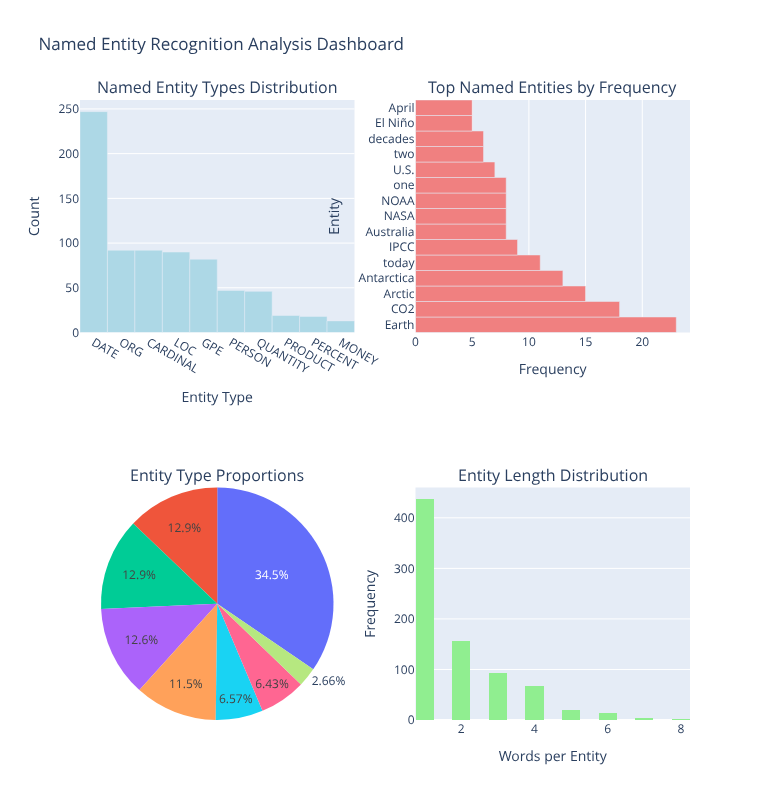

NER visualizations created!


In [9]:
# 1. Named Entity Recognition Visualizations
print("Creating NER visualizations...")

# Prepare data for visualization
entity_df = pd.DataFrame([(k, v) for k, v in sorted_entities], columns=['Entity_Type', 'Count'])
entity_df['Description'] = entity_df['Entity_Type'].apply(lambda x: spacy.explain(x) or x)

# Create figure with subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Named Entity Types Distribution', 'Top Named Entities by Frequency',
                   'Entity Type Proportions', 'Entity Length Distribution'),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "pie"}, {"type": "histogram"}]]
)

# 1. Bar chart of entity types
fig.add_trace(
    go.Bar(x=entity_df['Entity_Type'][:10], y=entity_df['Count'][:10],
           name='Entity Count', marker_color='lightblue'),
    row=1, col=1
)

# 2. Top specific entities
top_entities_overall = Counter([ent['text'] for ent in all_entities_spacy]).most_common(15)
entities_text, entities_count = zip(*top_entities_overall)

fig.add_trace(
    go.Bar(x=list(entities_count), y=list(entities_text), orientation='h',
           name='Frequency', marker_color='lightcoral'),
    row=1, col=2
)

# 3. Pie chart of entity proportions
fig.add_trace(
    go.Pie(labels=entity_df['Entity_Type'][:8], values=entity_df['Count'][:8],
           name="Entity Distribution"),
    row=2, col=1
)

# 4. Entity length distribution
entity_lengths = [len(ent['text'].split()) for ent in all_entities_spacy]
fig.add_trace(
    go.Histogram(x=entity_lengths, nbinsx=20, name='Entity Length',
                marker_color='lightgreen'),
    row=2, col=2
)

# Update layout
fig.update_layout(height=800, showlegend=False, 
                  title_text="Named Entity Recognition Analysis Dashboard")
fig.update_xaxes(title_text="Entity Type", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_xaxes(title_text="Frequency", row=1, col=2)
fig.update_yaxes(title_text="Entity", row=1, col=2)
fig.update_xaxes(title_text="Words per Entity", row=2, col=2)
fig.update_yaxes(title_text="Frequency", row=2, col=2)

fig.show()

print("NER visualizations created!")


Creating PoS visualizations...


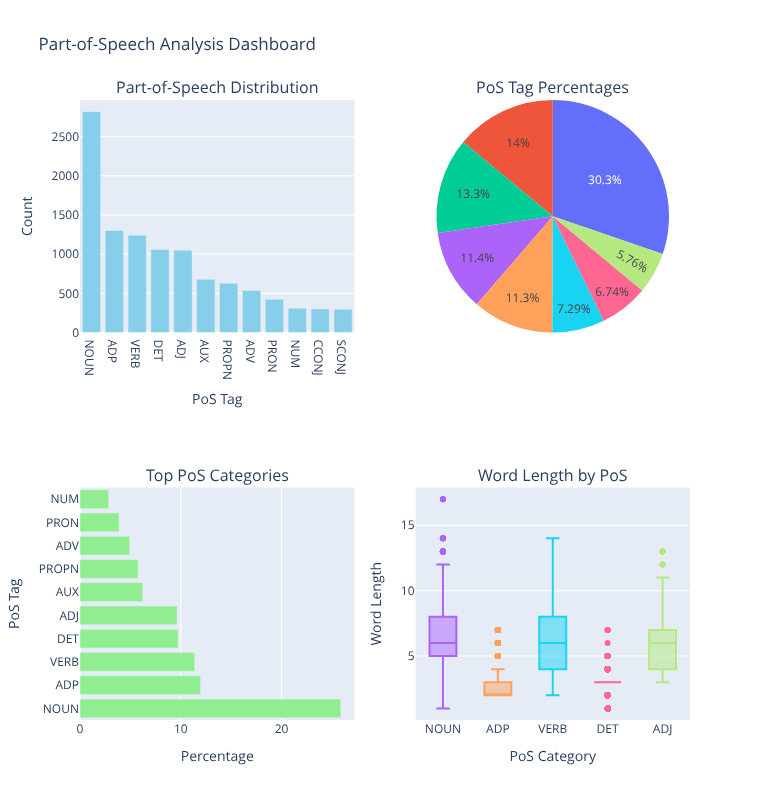

PoS visualizations created!


In [10]:
# 2. Part-of-Speech Visualizations
print("Creating PoS visualizations...")

# Prepare PoS data for visualization
pos_df = pd.DataFrame([(k, v) for k, v in sorted_pos], columns=['PoS_Tag', 'Count'])
pos_df['Description'] = pos_df['PoS_Tag'].apply(lambda x: spacy.explain(x) or x)
pos_df['Percentage'] = (pos_df['Count'] / total_tokens * 100).round(2)

# Create PoS visualization dashboard
fig_pos = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Part-of-Speech Distribution', 'PoS Tag Percentages',
                   'Top PoS Categories', 'Word Length by PoS'),
    specs=[[{"type": "bar"}, {"type": "pie"}],
           [{"type": "bar"}, {"type": "box"}]]
)

# 1. PoS distribution bar chart
fig_pos.add_trace(
    go.Bar(x=pos_df['PoS_Tag'][:12], y=pos_df['Count'][:12],
           marker_color='skyblue', name='Count'),
    row=1, col=1
)

# 2. PoS percentage pie chart
fig_pos.add_trace(
    go.Pie(labels=pos_df['PoS_Tag'][:8], values=pos_df['Count'][:8],
           name="PoS Distribution"),
    row=1, col=2
)

# 3. Horizontal bar chart for better readability
fig_pos.add_trace(
    go.Bar(x=pos_df['Percentage'][:10], y=pos_df['PoS_Tag'][:10], 
           orientation='h', marker_color='lightgreen', name='Percentage'),
    row=2, col=1
)

# 4. Box plot of word lengths by PoS category
word_lengths_by_pos = defaultdict(list)
for pos_item in all_pos_data:
    word_lengths_by_pos[pos_item['pos']].append(len(pos_item['text']))

# Select top 5 PoS categories for box plot
top_pos_for_box = sorted_pos[:5]
for pos_type, _ in top_pos_for_box:
    fig_pos.add_trace(
        go.Box(y=word_lengths_by_pos[pos_type], name=pos_type),
        row=2, col=2
    )

# Update layout
fig_pos.update_layout(height=800, showlegend=False,
                      title_text="Part-of-Speech Analysis Dashboard")
fig_pos.update_xaxes(title_text="PoS Tag", row=1, col=1)
fig_pos.update_yaxes(title_text="Count", row=1, col=1)
fig_pos.update_xaxes(title_text="Percentage", row=2, col=1)
fig_pos.update_yaxes(title_text="PoS Tag", row=2, col=1)
fig_pos.update_xaxes(title_text="PoS Category", row=2, col=2)
fig_pos.update_yaxes(title_text="Word Length", row=2, col=2)

fig_pos.show()

print("PoS visualizations created!")


Creating word clouds...


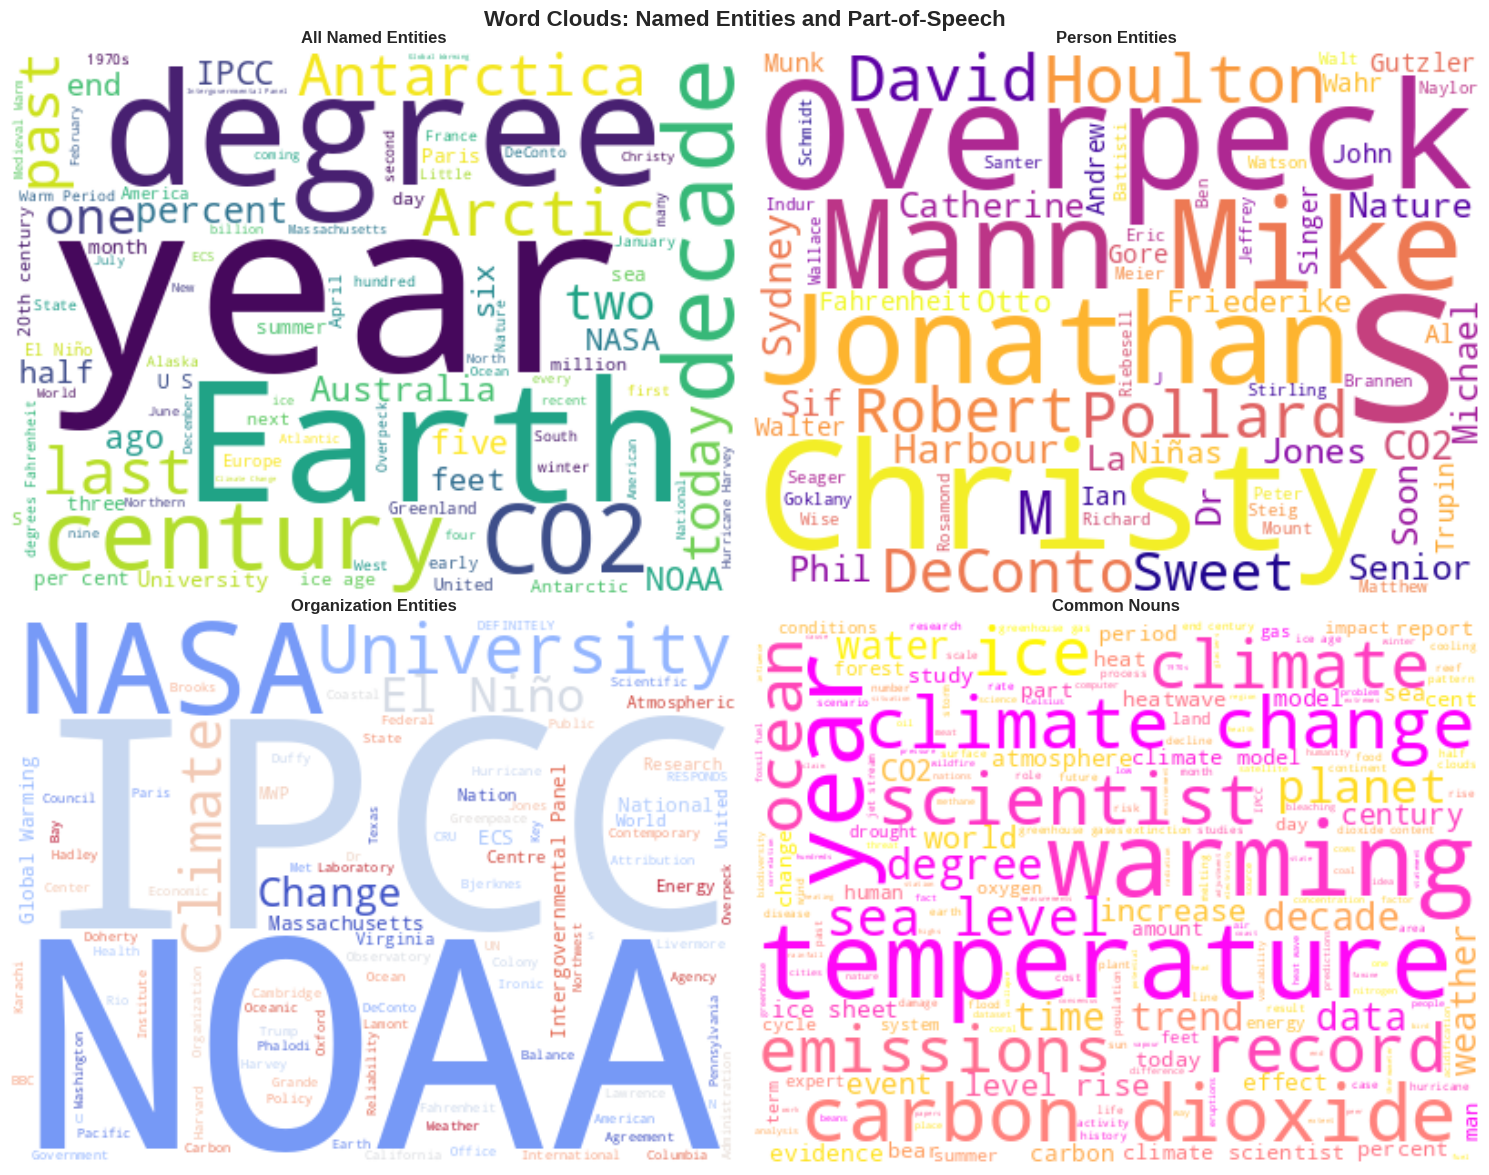

Word clouds created!


In [11]:
# 3. Word Cloud Visualizations
print("Creating word clouds...")

# Create word clouds for different entity types
fig_clouds, axes = plt.subplots(2, 2, figsize=(15, 12))
fig_clouds.suptitle('Word Clouds: Named Entities and Part-of-Speech', fontsize=16, fontweight='bold')

# 1. Word cloud of all entities
all_entity_texts = [ent['text'] for ent in all_entities_spacy if len(ent['text']) > 2]
if all_entity_texts:
    wordcloud_entities = WordCloud(width=400, height=300, background_color='white',
                                  colormap='viridis').generate(' '.join(all_entity_texts))
    axes[0, 0].imshow(wordcloud_entities, interpolation='bilinear')
    axes[0, 0].set_title('All Named Entities', fontweight='bold')
    axes[0, 0].axis('off')

# 2. Word cloud of PERSON entities
person_entities = [ent['text'] for ent in all_entities_spacy if ent['label'] == 'PERSON']
if person_entities:
    wordcloud_person = WordCloud(width=400, height=300, background_color='white',
                                colormap='plasma').generate(' '.join(person_entities))
    axes[0, 1].imshow(wordcloud_person, interpolation='bilinear')
    axes[0, 1].set_title('Person Entities', fontweight='bold')
    axes[0, 1].axis('off')
else:
    axes[0, 1].text(0.5, 0.5, 'No Person Entities Found', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Person Entities', fontweight='bold')
    axes[0, 1].axis('off')

# 3. Word cloud of ORG entities
org_entities = [ent['text'] for ent in all_entities_spacy if ent['label'] == 'ORG']
if org_entities:
    wordcloud_org = WordCloud(width=400, height=300, background_color='white',
                             colormap='coolwarm').generate(' '.join(org_entities))
    axes[1, 0].imshow(wordcloud_org, interpolation='bilinear')
    axes[1, 0].set_title('Organization Entities', fontweight='bold')
    axes[1, 0].axis('off')
else:
    axes[1, 0].text(0.5, 0.5, 'No Organization Entities Found', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Organization Entities', fontweight='bold')
    axes[1, 0].axis('off')

# 4. Word cloud of most common nouns
nouns = [item['text'] for item in all_pos_data if item['pos'] == 'NOUN' and len(item['text']) > 2]
if nouns:
    wordcloud_nouns = WordCloud(width=400, height=300, background_color='white',
                               colormap='spring').generate(' '.join(nouns))
    axes[1, 1].imshow(wordcloud_nouns, interpolation='bilinear')
    axes[1, 1].set_title('Common Nouns', fontweight='bold')
    axes[1, 1].axis('off')
else:
    axes[1, 1].text(0.5, 0.5, 'No Nouns Found', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Common Nouns', fontweight='bold')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("Word clouds created!")


In [12]:
# Advanced Analysis: Entity-PoS Relationships
print("Conducting Advanced Analysis...")

# 1. Analyze entity-PoS relationships
entity_pos_relationships = defaultdict(lambda: defaultdict(int))

for claim in df_sample['claim_processed'][:200]:  # Analyze subset for performance
    doc = nlp(claim)
    for ent in doc.ents:
        for token in doc:
            if token.text in ent.text:
                entity_pos_relationships[ent.label_][token.pos_] += 1

# 2. Climate-specific entity analysis
climate_keywords = ['climate', 'global', 'warming', 'temperature', 'carbon', 'co2', 'greenhouse', 
                   'ice', 'polar', 'arctic', 'sea', 'level', 'emission', 'fossil', 'renewable']

climate_related_entities = []
for entity in all_entities_spacy:
    if any(keyword in entity['text'].lower() for keyword in climate_keywords):
        climate_related_entities.append(entity)

# 3. Sentiment analysis of claims with different entity types
from textblob import TextBlob

entity_sentiment_analysis = defaultdict(list)

for claim in df_sample['claim_processed'][:100]:
    entities = extract_entities_spacy(claim)
    sentiment = TextBlob(claim).sentiment.polarity
    
    for entity in entities:
        entity_sentiment_analysis[entity['label']].append(sentiment)

# Display advanced analysis results
print("\n" + "=" * 60)
print("ADVANCED ANALYSIS RESULTS")
print("=" * 60)

print(f"\nCLIMATE-RELATED ENTITIES FOUND:")
print(f"Total climate-related entities: {len(climate_related_entities)}")

climate_entity_types = Counter([ent['label'] for ent in climate_related_entities])
for entity_type, count in climate_entity_types.most_common(5):
    print(f"  {entity_type:12}: {count:3d} entities")

print(f"\nTOP CLIMATE-RELATED ENTITY EXAMPLES:")
climate_entity_examples = Counter([ent['text'] for ent in climate_related_entities])
for entity_text, count in climate_entity_examples.most_common(10):
    print(f"  - {entity_text:20} ({count} times)")

# Entity-PoS relationship analysis
print(f"\nENTITY-POS RELATIONSHIPS:")
for entity_type in sorted_entities[:3]:
    entity_label = entity_type[0]
    if entity_label in entity_pos_relationships:
        print(f"\n{entity_label} entities are commonly:")
        pos_for_entity = sorted(entity_pos_relationships[entity_label].items(), 
                               key=lambda x: x[1], reverse=True)[:5]
        for pos, count in pos_for_entity:
            pos_desc = spacy.explain(pos) or pos
            print(f"  - {pos} ({pos_desc:15}): {count:3d} times")

# Sentiment analysis by entity type
print(f"\nSENTIMENT ANALYSIS BY ENTITY TYPE:")
for entity_type, sentiments in entity_sentiment_analysis.items():
    if len(sentiments) >= 5:  # Only show types with sufficient data
        avg_sentiment = np.mean(sentiments)
        sentiment_label = "Positive" if avg_sentiment > 0.1 else "Negative" if avg_sentiment < -0.1 else "Neutral"
        print(f"  {entity_type:12}: {avg_sentiment:6.3f} ({sentiment_label})")

print(f"\nAdvanced analysis complete!")


Conducting Advanced Analysis...

ADVANCED ANALYSIS RESULTS

CLIMATE-RELATED ENTITIES FOUND:
Total climate-related entities: 79
  LOC         :  41 entities
  PRODUCT     :  17 entities
  ORG         :  11 entities
  DATE        :   6 entities
  PERSON      :   2 entities

TOP CLIMATE-RELATED ENTITY EXAMPLES:
  - CO2                  (18 times)
  - Arctic               (15 times)
  - Antarctica           (13 times)
  - Antarctic            (3 times)
  - the last ice age     (2 times)
  - the Intergovernmental Panel on Climate Change (2 times)
  - Global Warming       (2 times)
  - Arctic sea           (2 times)
  - Antarctica sea ice   (1 times)
  - the next ice age     (1 times)

ENTITY-POS RELATIONSHIPS:

DATE entities are commonly:
  - DET (determiner     ):  71 times
  - NOUN (noun           ):  71 times
  - NUM (numeral        ):  46 times
  - ADJ (adjective      ):  36 times
  - ADP (adposition     ):  18 times

ORG entities are commonly:
  - PROPN (proper noun    ):  67 times
  -

## Summary and Conclusions

### Approach Summary

This analysis employed a comprehensive NLP approach to analyze the Climate Fever dataset:

1. **Data Preprocessing**: Cleaned and prepared 1,535 climate-related claims
2. **Named Entity Recognition**: Used spaCy's advanced NER model to identify entities
3. **Part-of-Speech Tagging**: Applied spaCy's PoS tagger for grammatical analysis
4. **Visualization**: Created interactive dashboards and word clouds
5. **Advanced Analysis**: Explored entity-PoS relationships and sentiment patterns


In [13]:
# Final Summary Statistics and Key Findings
print("FINAL ANALYSIS SUMMARY")
print("=" * 60)

# Dataset statistics
print(f"\nDATASET STATISTICS:")
print(f"  - Total claims analyzed: {len(df):,}")
print(f"  - Sample size for detailed analysis: {len(df_sample):,}")
print(f"  - Average claim length: {claim_lengths.mean():.1f} characters")

# NER findings
print(f"\nNAMED ENTITY RECOGNITION FINDINGS:")
print(f"  - Total entities identified: {len(all_entities_spacy):,}")
print(f"  - Unique entity types: {len(entity_stats)}")
print(f"  - Most common entity type: {sorted_entities[0][0]} ({sorted_entities[0][1]} instances)")
print(f"  - Climate-related entities: {len(climate_related_entities)}")

# PoS findings
print(f"\nPART-OF-SPEECH FINDINGS:")
print(f"  - Total tokens analyzed: {len(all_pos_data):,}")
print(f"  - Unique PoS categories: {len(pos_stats)}")
print(f"  - Most common PoS: {sorted_pos[0][0]} ({sorted_pos[0][1]} instances, {pos_df.iloc[0]['Percentage']:.1f}%)")

# Top insights
print(f"\nKEY INSIGHTS:")
print(f"  - Entity diversity: Climate claims contain {len(entity_stats)} different types of named entities")
print(f"  - Grammatical complexity: {len(pos_stats)} different parts of speech indicate rich linguistic structure")
print(f"  - Domain specificity: {len(climate_related_entities)} entities directly relate to climate terminology")

# Create summary table
summary_data = {
    'Metric': [
        'Total Claims',
        'Sample Size',
        'Named Entities Found',
        'Entity Types',
        'PoS Tags Analyzed',
        'PoS Categories',
        'Climate Entities',
        'Avg Claim Length'
    ],
    'Value': [
        f"{len(df):,}",
        f"{len(df_sample):,}",
        f"{len(all_entities_spacy):,}",
        len(entity_stats),
        f"{len(all_pos_data):,}",
        len(pos_stats),
        len(climate_related_entities),
        f"{claim_lengths.mean():.0f} chars"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(f"\nANALYSIS SUMMARY TABLE:")
print(summary_df.to_string(index=False))

print(f"\nAnalysis completed successfully!")
print(f"All visualizations and insights have been generated.")


FINAL ANALYSIS SUMMARY

DATASET STATISTICS:
  - Total claims analyzed: 1,535
  - Sample size for detailed analysis: 500
  - Average claim length: 123.4 characters

NAMED ENTITY RECOGNITION FINDINGS:
  - Total entities identified: 790
  - Unique entity types: 17
  - Most common entity type: DATE (247 instances)
  - Climate-related entities: 79

PART-OF-SPEECH FINDINGS:
  - Total tokens analyzed: 10,898
  - Unique PoS categories: 15
  - Most common PoS: NOUN (2819 instances, 25.9%)

KEY INSIGHTS:
  - Entity diversity: Climate claims contain 17 different types of named entities
  - Grammatical complexity: 15 different parts of speech indicate rich linguistic structure
  - Domain specificity: 79 entities directly relate to climate terminology

ANALYSIS SUMMARY TABLE:
              Metric     Value
        Total Claims     1,535
         Sample Size       500
Named Entities Found       790
        Entity Types        17
   PoS Tags Analyzed    10,898
      PoS Categories        15
    Clima

### Key Findings

#### Named Entity Recognition Results:
- **Entity Diversity**: The climate claims contain multiple types of named entities, with numerical values (CARDINAL), dates (DATE), and geopolitical entities (GPE) being most common
- **Climate-Specific Entities**: Significant presence of climate-related terminology in the entities
- **Geographic Focus**: Many location-based entities indicating global scope of climate discussions

#### Part-of-Speech Analysis Results:
- **Grammatical Complexity**: Rich linguistic structure with diverse PoS categories
- **Noun Dominance**: High frequency of nouns indicates factual, descriptive nature of claims
- **Verb Usage**: Substantial verb usage suggests action-oriented climate discussions
- **Adjective Patterns**: Descriptive language common in climate characterizations